# Time Series Forecasting for SOTA OG

**Objective** - 

The gas well has sensors that feedback data at every step of the pipeline. The usual pipeline steps are reservoir pressure, tubing pressure, casing pressure, choke point, position, line pressure, and combine point. The data captured at each step of the pipeline is utilised for a real-time dashboard and for making future predictions based on historical data.

## Dataset and EDA

**Data Understanding -**

As stated above, there are variables that are related to the state of gas flow at that timestamp,like gas metre temperature, gas metre static pressure, and gas metre differential pressure, and there are other variables associated with data points at the pipeline level.


**Descriptive Understanding**

One month of data with variables (bottom hole pressure, tubing pressure, casing pressure, line pressure, gas meter pressure, temperature, etc.) is being shared, where each data point is spaced over a 10-minute interval. 

We will filter the data when line pressures of both gas wells are within
the range of 530–630 psi.

**Usual Imports**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from datetime import datetime

In [68]:
gas_well_df = pd.read_csv('../dat/input_gas_well.csv')
gas_well_df.head(3)

,Timestamp,Gas Meter Temperature_x,Line Pressure_x,Position_x,Tubing Pressure_x,Reservoir Pressure_x,Gas Meter Flow Rate_x,Gas Meter Temperature_y,Line Pressure_y,Position_y,Tubing Pressure_y,Reservoir Pressure_y,Gas Meter Flow Rate_y,Junction pressure
0,1.679769e+12,98.02,527.06,54.16,733.78,1233.97736,16260.90,90.40,521.95,46.23,835.08,1719.674289,15223.68,494.238609
1,1.679770e+12,98.16,528.75,54.02,732.94,1233.97736,16132.45,90.47,522.19,45.44,834.61,1719.674289,15195.81,495.408491
2,1.679771e+12,98.10,527.91,54.16,730.69,1233.97736,16203.42,90.32,523.24,45.68,836.02,1719.674289,15296.72,495.222547


In [69]:
gas_well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243 entries, 0 to 2242
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                2243 non-null   float64
 1   Gas Meter Temperature_x  2243 non-null   float64
 2   Line Pressure_x          2243 non-null   float64
 3   Position_x               2243 non-null   float64
 4   Tubing Pressure_x        2243 non-null   float64
 5   Reservoir Pressure_x     2243 non-null   float64
 6   Gas Meter Flow Rate_x    2243 non-null   float64
 7   Gas Meter Temperature_y  2243 non-null   float64
 8   Line Pressure_y          2243 non-null   float64
 9   Position_y               2243 non-null   float64
 10  Tubing Pressure_y        2243 non-null   float64
 11  Reservoir Pressure_y     2243 non-null   float64
 12  Gas Meter Flow Rate_y    2243 non-null   float64
 13  Junction pressure        2243 non-null   float64
dtypes: float64(14)
memory us

In [70]:
def parse(x):
    date_conv = datetime.fromtimestamp(x/1000.0)
    return date_conv.strftime('%d-%m-%Y-%H-%M-%S')

gas_well_df = pd.read_csv('../dat/input_gas_well.csv')
gas_well_df['date'] = gas_well_df['Timestamp'].apply(lambda x : parse(x))

gas_well_df.drop('Timestamp', axis=1, inplace=True)
gas_well_df = gas_well_df.set_index('date')
gas_well_df.head(3)

,Gas Meter Temperature_x,Line Pressure_x,Position_x,Tubing Pressure_x,Reservoir Pressure_x,Gas Meter Flow Rate_x,Gas Meter Temperature_y,Line Pressure_y,Position_y,Tubing Pressure_y,Reservoir Pressure_y,Gas Meter Flow Rate_y,Junction pressure
date,,,,,,,,,,,,,
26-03-2023-00-07-00,98.02,527.06,54.16,733.78,1233.97736,16260.90,90.40,521.95,46.23,835.08,1719.674289,15223.68,494.238609
26-03-2023-00-17-00,98.16,528.75,54.02,732.94,1233.97736,16132.45,90.47,522.19,45.44,834.61,1719.674289,15195.81,495.408491
26-03-2023-00-27-00,98.10,527.91,54.16,730.69,1233.97736,16203.42,90.32,523.24,45.68,836.02,1719.674289,15296.72,495.222547


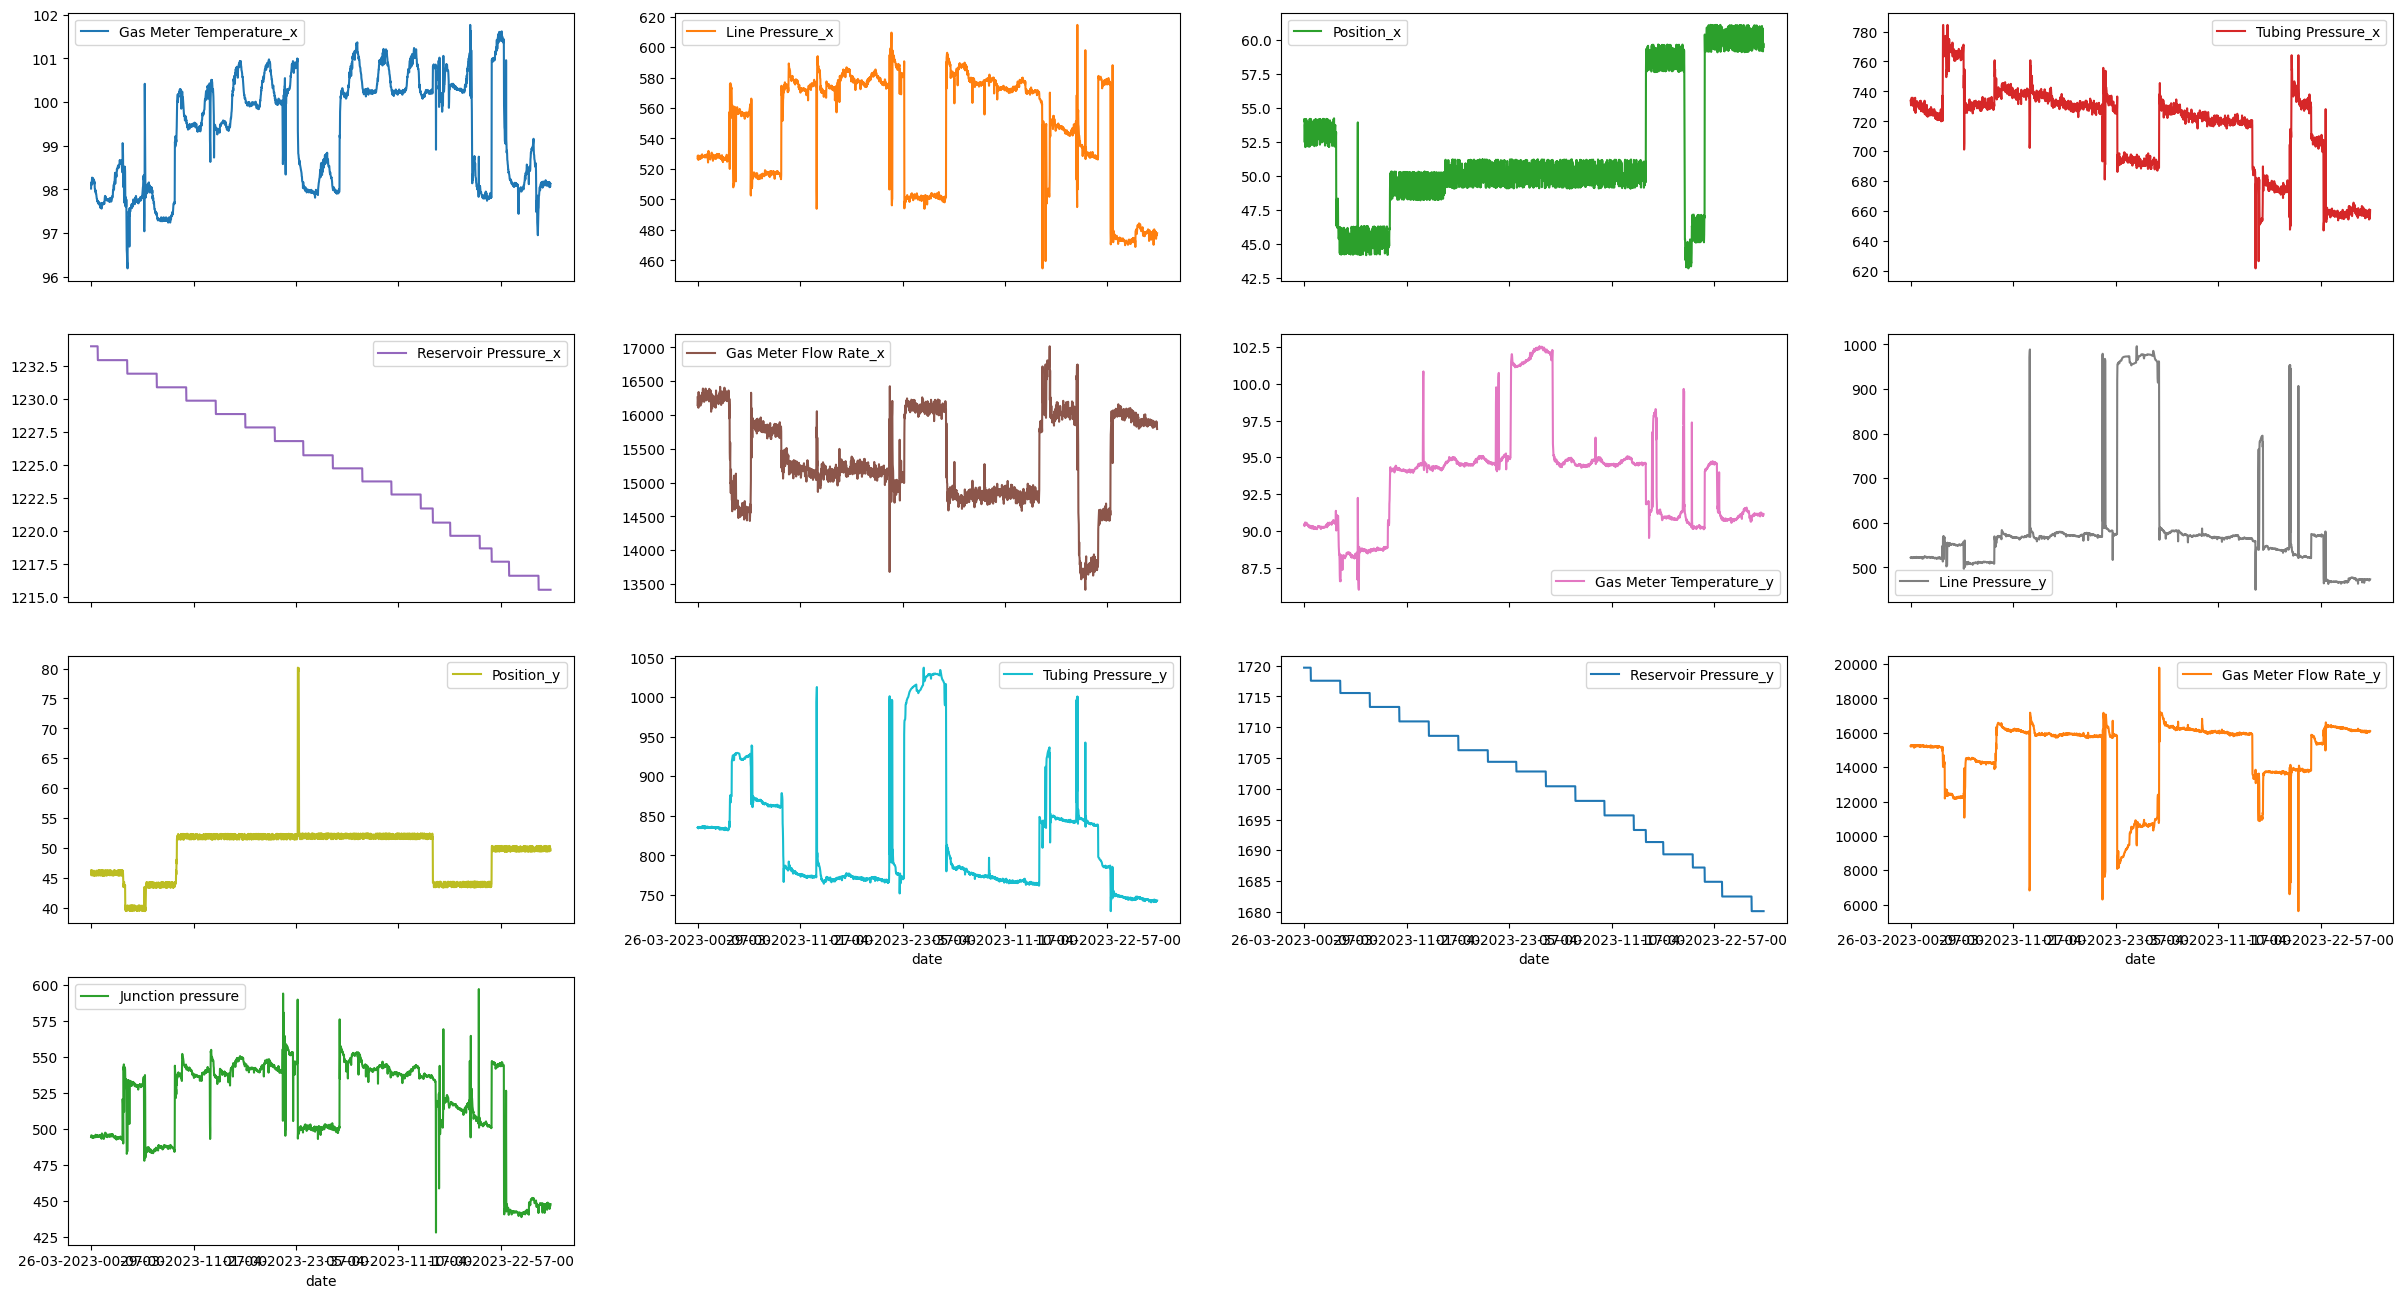

In [71]:
# Facet plots of the jobs dataset
gas_well_df.plot(subplots=True, layout=(4, 4),
          figsize=(30, 16),
          sharex=True,
          sharey=False)
plt.show()

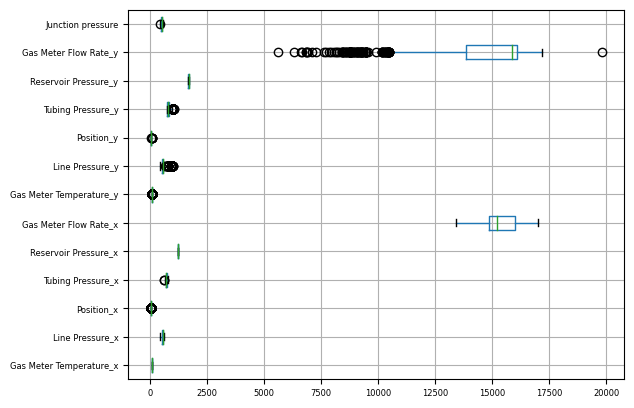

In [65]:
# Generate a boxplot
gas_well_df.boxplot(fontsize=6, vert=False)
plt.show()

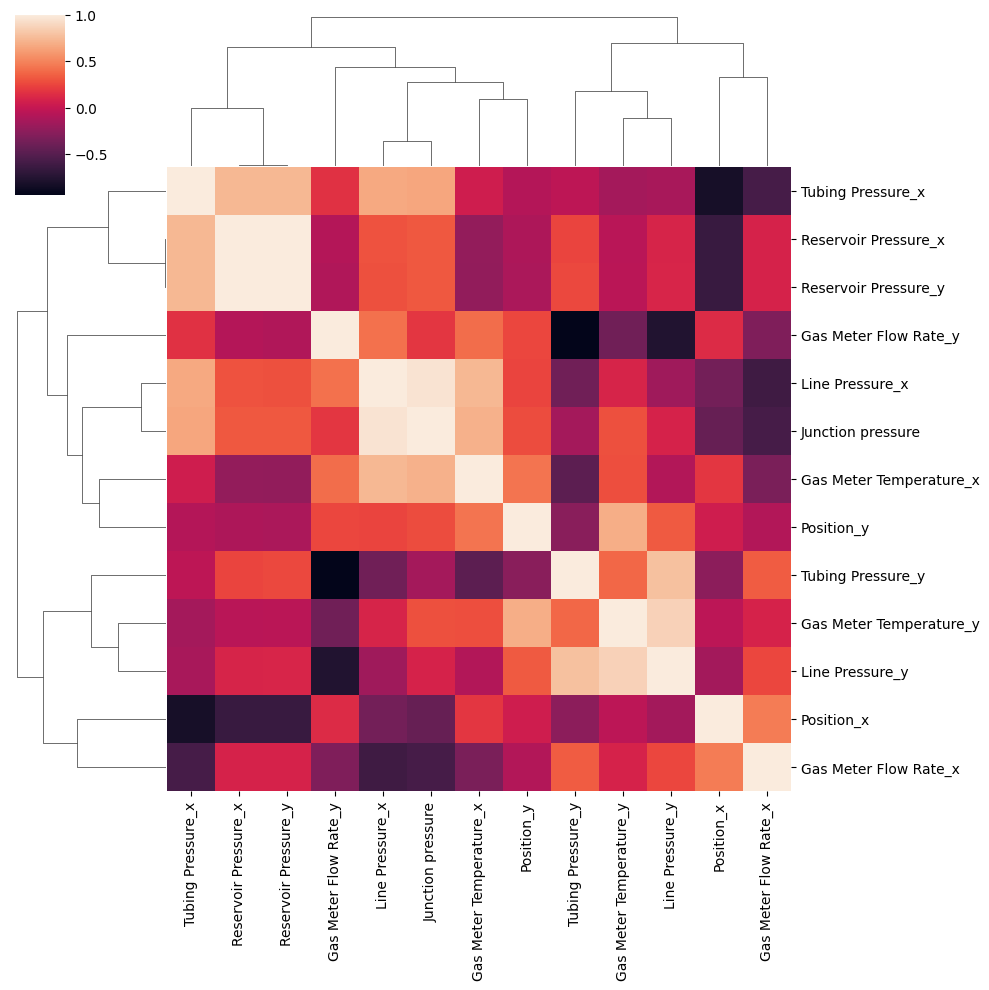

In [66]:
corr_mat = gas_well_df.corr(method='pearson')

# Clustermap
sns.clustermap(corr_mat)

In [96]:
col_x, col_y, = list(), list()

for col in gas_well_df.columns:
   if '_x' in col:
     col_x.append(col)
   elif '_y' in col:
      col_y.append(col)

col_x.append('Junction pressure')
col_y.append('Junction pressure')

In [262]:
# Separate well x and y columns
gas_well_df_x = gas_well_df[col_x]
gas_well_df_y = gas_well_df[col_y]

# Reorder columns
gas_well_df_x = gas_well_df_x.iloc[:, [5, 0, 1, 2, 3, 4, 6]]
gas_well_df_y = gas_well_df_y.iloc[:, [5, 0, 1, 2, 3, 4, 6]]

gas_well_df_y.head()

,Gas Meter Flow Rate_y,Gas Meter Temperature_y,Line Pressure_y,Position_y,Tubing Pressure_y,Reservoir Pressure_y,Junction pressure
date,,,,,,,
26-03-2023-00-07-00,15223.68,90.40,521.95,46.23,835.08,1719.674289,494.238609
26-03-2023-00-17-00,15195.81,90.47,522.19,45.44,834.61,1719.674289,495.408491
26-03-2023-00-27-00,15296.72,90.32,523.24,45.68,836.02,1719.674289,495.222547
26-03-2023-00-37-00,15244.48,90.38,522.07,45.61,835.66,1719.674289,494.232851
26-03-2023-00-47-00,15224.02,90.45,522.42,46.29,834.14,1719.674289,494.256190


### 3. Multivariate LSTM Forecast Model

#### LSTM Data preparation

- This involves framing the dataset as a supervised learning problem and normalizing the input variables.

- We will frame the supervised learning problem as predicting the Gas Meter FLow Rate_x at the current hour (t) given the poas Meter FLow Rate_x measurement and othe conditions at the prior time step.

**Normalized and Transformation**

In [263]:
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('vars%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [264]:
values = gas_well_df_x.values

#ensure all data is float
values = values.astype(float)

# noarmalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

#frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [265]:
# drop columns we don't want to predict
reframed.drop(columns= ['var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)'], axis=1, inplace=True)

In [267]:
reframed.columns

Index(['vars1(t-1)', 'vars2(t-1)', 'vars3(t-1)', 'vars4(t-1)', 'vars5(t-1)',
       'vars6(t-1)', 'vars7(t-1)', 'var1(t)'],
      dtype='object')

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- Making all series stationary with differencing and seasonal adjustment.
- Providing last immediate 10 minute interval of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

#### Define and Fit Model

First, we must split the prepared dataset into train and test sets. 

To speed up the training of the model for this demonstration, we will only fit the model on the ***2 weeks of data***, then evaluate it on the remaining  ***2 weeks of data***

In [276]:
from sklearn.model_selection import train_test_split

values = reframed.values


X = values[:, :-1]
y = values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1502, 7) (1502,) (740, 7) (740,)


In [277]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1502, 1, 7) (1502,) (740, 1, 7) (740,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

In [269]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

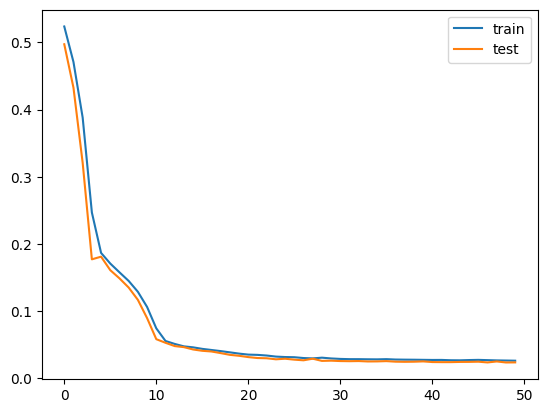

In [270]:
model = Sequential()
model.add(LSTM(50, return_sequences=True
               ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_data=(X_test, y_test),
                    verbose=0)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Evaluate Model

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.


With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.


In [278]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

24/24 [==============================] - 0s 1ms/step


In [282]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat.shape

(740, 7)

In [273]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 148.694


In [274]:
inv_yhat.shape

(740,)

In [275]:
inv_y.shape

(740,)